## Preliminaries

In [ ]:
!pip -q install wfdb imbalanced-learn

import os
import wfdb
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPooling1D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 5.5 MB/s eta 0:00:00


In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    project_directory = '/content/drive/MyDrive/TinyML-ECG/TinyRhythmAnalyzer/'  # Change this path to match your Google Drive directory
    os.chdir(project_directory)
except:
    pass

Mounted at /content/drive


## Data Visualization

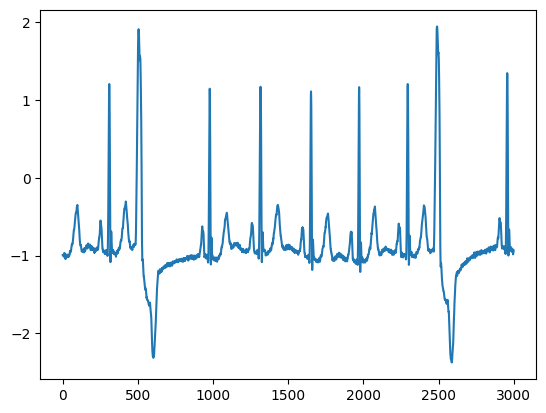

In [ ]:
# Specify the record name and path
record_name = '119'
record_path = f'./mit-bih-arrhythmia-database-1.0.0/{record_name}'

# Read the ECG record. We can optionally pass in the `sampto` parameter to read a specific number of samples. Let's try 3000.
record = wfdb.rdrecord(record_path, sampto=3000)

# Extract the ECG signal from the first lead of the record
ecg_signal = record.p_signal[:,0]

# Plotting the ECG signal
plt.plot(ecg_signal)

## Data Preprocessing

In [ ]:
record_name = '101'
record_path = f'./mit-bih-arrhythmia-database-1.0.0/{record_name}'
record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(record_path, 'atr')

In [ ]:
peaks = annotation.sample
symbols = annotation.symbol

In [ ]:
print(peaks[:10])
print(symbols[:10])

[   7   83  396  711 1032 1368 1712 2036 2349 2662]
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


In [ ]:
data_path = './mit-bih-arrhythmia-database-1.0.0/'
record_list = wfdb.get_record_list('mitdb')

In [ ]:
X = []  # R-R intervals
y = []  # labels (normal = 0, arrhythmic = 1)

window_size = 10

for record_name in record_list:
    # Load the signal and annotations
    annotation = wfdb.rdann(os.path.join(data_path, record_name), 'atr')

    # Detect peaks
    peaks = annotation.sample

    # Get R-R intervals
    intervals = np.diff(peaks)

    # Normalize the intervals
    normalized_intervals = intervals / intervals.max()

    # Break up the intervals into segments of 10
    for i in range(len(intervals) - window_size + 1):
        # Get the annotations and intervals for the current window
        window_annotations = annotation.symbol[i:i + window_size]
        window_intervals = normalized_intervals[i:i + window_size]

        # Count of abnormal beats
        abnormal_count = sum(1 for ann in window_annotations if ann == 'V')

        # Select windows that are either all 'N' or have at least 2 'V's
        if all(ann == 'N' for ann in window_annotations) or (abnormal_count >= 2):
            X.append(window_intervals)
            y.append(abnormal_count >= 2)

In [ ]:
X = np.array(X)
y = np.array(y)

Text(0, 0.5, 'arrhythmia score')

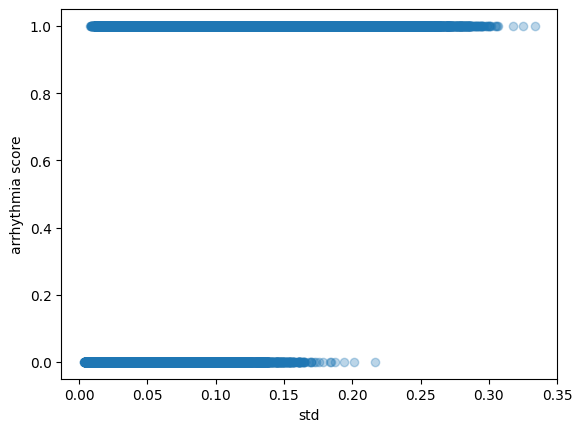

In [ ]:
plt.scatter(np.std(X, axis=1), y, alpha=0.3)
plt.xlabel("std")
plt.ylabel("arrhythmia score")

## 2.4 Data Balancing

Text(0, 0.5, 'Count')

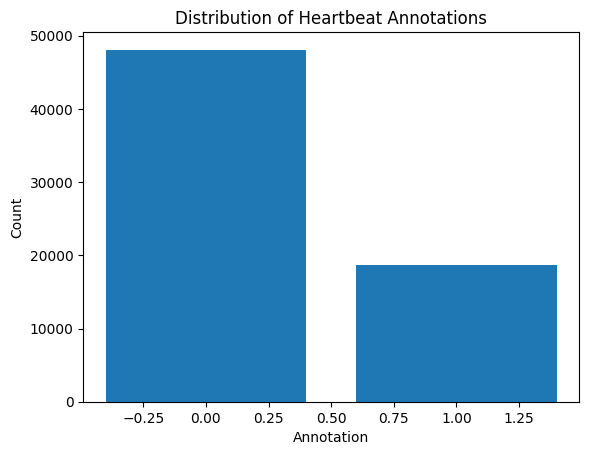

In [ ]:
annotation_counter = Counter()
annotation_counter.update(y)

plt.bar(annotation_counter.keys(), annotation_counter.values())
plt.title('Distribution of Heartbeat Annotations')
plt.xlabel('Annotation')
plt.ylabel('Count')

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

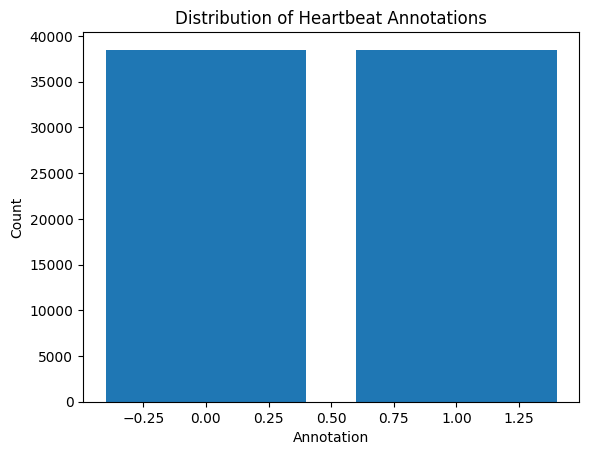

In [ ]:
# Fix class imbalance
smote = SMOTE()

# Fit SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

annotation_smote_counter = Counter()
annotation_smote_counter.update(y_train_smote)

plt.bar(annotation_smote_counter.keys(), annotation_smote_counter.values())
plt.title('Distribution of Heartbeat Annotations')
plt.xlabel('Annotation')
plt.ylabel('Count')
plt.show()

## 2.5 Model Training

In [ ]:
# Define the modle
model = Sequential([
    Dense(16, input_dim=window_size, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
# model = Sequential([
#     Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(window_size, 1)),
#     MaxPooling1D(pool_size=2),
#     Flatten(),
#     Dense(8, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    X_train_smote,
    y_train_smote,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
1925/1925 [==============================] - 5s 2ms/step - loss: 0.3718 - accuracy: 0.8240 - val_loss: 0.3394 - val_accuracy: 0.8645
Epoch 2/5
1925/1925 [==============================] - 3s 1ms/step - loss: 0.2062 - accuracy: 0.9204 - val_loss: 0.3388 - val_accuracy: 0.8755
Epoch 3/5
1925/1925 [==============================] - 3s 2ms/step - loss: 0.1916 - accuracy: 0.9265 - val_loss: 0.2408 - val_accuracy: 0.9196
Epoch 4/5
1925/1925 [==============================] - 3s 2ms/step - loss: 0.1850 - accuracy: 0.9289 - val_loss: 0.2479 - val_accuracy: 0.9186
Epoch 5/5
1925/1925 [==============================] - 3s 2ms/step - loss: 0.1797 - accuracy: 0.9309 - val_loss: 0.2071 - val_accuracy: 0.9354


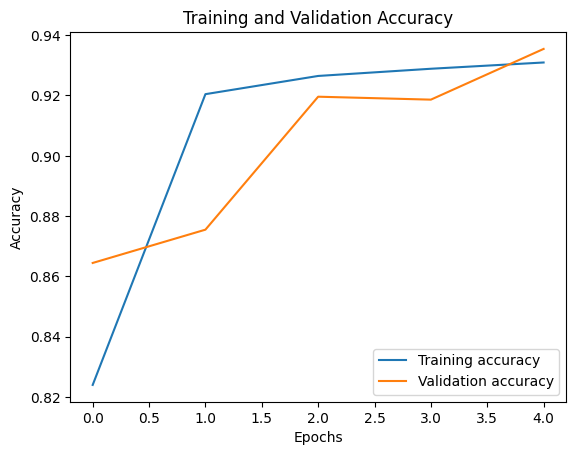

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

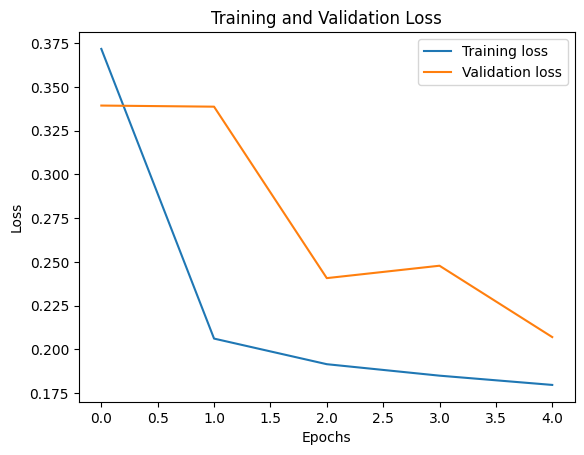

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model and print the accuracy
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {accuracy}')
print(f'Loss: {loss}')

Test accuracy: 0.9248334169387817
Loss: 0.18364550173282623


## 2.6 Exporting the Model

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
!apt-get -qq install xxd
!xxd -i model.tflite > model.cpp
!cat model.cpp

unsigned char model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x84, 0x00, 0x00, 0x00, 0xdc, 0x00, 0x00, 0x00, 0xfc, 0x06, 0x00, 0x00,
  0x0c, 0x07, 0x00, 0x00, 0xac, 0x0c, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xb6, 0xf8, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x98, 0xff, 0xff, 0xff, 0x0a, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x32, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xa2, 0xf9, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x0b, 0x00, 0x00, 0x00,
  0x6

## Print Test Data

In [31]:
# Python code to create C-style header and source files
# from numpy arrays 'X_test' and 'y_test'.

def write_array_to_files(basename, array, num_trials):
    # Create the source file content
    cpp_content = f"""#include "{basename}_intervals.h"

const int num_{basename}_trials = {num_trials};
float {basename}_intervals[{num_trials}][10] = {{
"""
    for row in array:
        cpp_content += "    {" + ", ".join(f"{x:.6f}" for x in row) + "},\n"
    cpp_content += "};\n"

    # Write to the source file
    with open(f"{basename}_intervals.cpp", "w") as f:
        f.write(cpp_content)


# First, we filter out the arrhythmic and normal intervals
num_trails = 20
arrhythmic_indices = np.where(y_test == True)[0][:num_trails]
normal_indices = np.where(y_test == False)[0][:num_trails]

arrhythmic_intervals = X_test[arrhythmic_indices]
normal_intervals = X_test[normal_indices]

# Then, we call the function to print the c-style arrays into .h and .cpp files
write_array_to_files('arrhythmic', arrhythmic_intervals, num_trails)
write_array_to_files('normal', normal_intervals, num_trails)

In [34]:
!cat arrhythmic_intervals.cpp

#include "arrhythmic_intervals.h"

const int num_arrhythmic_trials = 20;
float arrhythmic_intervals[20][10] = {
    {0.521583, 0.248201, 0.796763, 0.550360, 0.526978, 0.163669, 0.165468, 0.739209, 0.464029, 0.343525},
    {0.416139, 0.356013, 0.363924, 0.397152, 0.352848, 0.362342, 0.381329, 0.275316, 0.545886, 0.409810},
    {0.466387, 0.796218, 0.363445, 0.718487, 0.418067, 0.380252, 0.380252, 0.590336, 0.573529, 0.605042},
    {0.548718, 0.343590, 1.000000, 0.741026, 0.725641, 0.469231, 0.948718, 0.741026, 0.733333, 0.464103},
    {0.544118, 0.481092, 0.397059, 0.575630, 0.222689, 0.224790, 0.911765, 0.418067, 0.714286, 0.443277},
    {0.186424, 0.263425, 0.231003, 0.220871, 0.203647, 0.328267, 0.202634, 0.263425, 0.226950, 0.197568},
    {0.370253, 0.384494, 0.137658, 0.137658, 0.536392, 0.420886, 0.162975, 0.101266, 0.443038, 0.473101},
    {0.376689, 0.687500, 0.368243, 0.638514, 0.476351, 0.439189, 0.479730, 0.589527, 0.548986, 0.555743},
    {0.776163, 0.613372, 0.593023, 0.601

In [35]:
!cat normal_intervals.cpp

#include "normal_intervals.h"

const int num_normal_trials = 20;
float normal_intervals[20][10] = {
    {0.555556, 0.462963, 0.410774, 0.427609, 0.335017, 0.575758, 0.331650, 0.523569, 0.449495, 0.427609},
    {0.732187, 0.756757, 0.746929, 0.727273, 0.710074, 0.707617, 0.690418, 0.714988, 0.724816, 0.754300},
    {0.700246, 0.660934, 0.668305, 0.744472, 0.751843, 0.685504, 0.695332, 0.700246, 0.710074, 0.658477},
    {0.783439, 0.783439, 0.690021, 0.685775, 0.743100, 0.751592, 0.734607, 0.668790, 0.747346, 0.787686},
    {0.757764, 0.739130, 0.720497, 0.773292, 0.763975, 0.748447, 0.729814, 0.748447, 0.736025, 0.757764},
    {0.749280, 0.746398, 0.740634, 0.743516, 0.772334, 0.740634, 0.752161, 0.731988, 0.729107, 0.740634},
    {0.616633, 0.626775, 0.618661, 0.626775, 0.622718, 0.624746, 0.649087, 0.555781, 0.679513, 0.655172},
    {0.717391, 0.704969, 0.711180, 0.692547, 0.720497, 0.723602, 0.711180, 0.692547, 0.704969, 0.708075},
    {0.725424, 0.738983, 0.713559, 0.677966, 0.68305